# Import Libraries

In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [2]:
bucket_name = 'creditriskdata' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://creditriskdata/built-in-algo/output


In [5]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://creditriskdata.s3.amazonaws.com/loan_data_inputs_train.csv", "loan_data_inputs_train.csv")
    print('Success: downloaded loan_data_inputs_train.csv')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./loan_data_inputs_train.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded loan_data_inputs_train.csv
Success: Data loaded into dataframe.


In [6]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://creditriskdata.s3.amazonaws.com/loan_data_inputs_test.csv", "loan_data_inputs_test.csv")
    print('Success: downloaded loan_data_inputs_test.csv')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./loan_data_inputs_test.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded loan_data_inputs_test.csv
Success: Data loaded into dataframe.


In [7]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://creditriskdata.s3.amazonaws.com/loan_data_targets_test.csv", "loan_data_targets_test.csv")
    print('Success: downloaded loan_data_targets_test.csv')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./loan_data_targets_test.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded loan_data_targets_test.csv
Success: Data loaded into dataframe.


In [8]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://creditriskdata.s3.amazonaws.com/loan_data_targets_train.csv", "loan_data_targets_train.csv")
    print('Success: downloaded loan_data_targets_train.csv')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./loan_data_targets_train.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded loan_data_targets_train.csv
Success: Data loaded into dataframe.


In [9]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://creditriskdata.s3.amazonaws.com/test_data.csv", "test_data.csv")
    print('Success: downloaded test_data.csv')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./test_data.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded test_data.csv
Success: Data loaded into dataframe.


# Loading the Data and Selecting the Features

### Import Data

In [10]:
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('loan_data_targets_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('loan_data_targets_test.csv', index_col = 0)
test_data = pd.read_csv('test_data.csv', index_col = 0)

### Explore Data

In [11]:
loan_data_inputs_train.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,mths_since_last_record:>86,total_rev_hi_lim:Missing,total_rev_hi_lim:<=5K,total_rev_hi_lim:5K-10K,total_rev_hi_lim:10K-20K,total_rev_hi_lim:20K-30K,total_rev_hi_lim:30K-40K,total_rev_hi_lim:40K-55K,total_rev_hi_lim:55K-95K,total_rev_hi_lim:>95K
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,0,0,0,0,0,0,0,0,1,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,0,0,0,1,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,0,1,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,0,0,1,0,0,0,0,0,0


In [12]:
loan_data_targets_train.head()

,good_bad
427211,1
206088,1
136020,1
412305,0
36159,0


In [13]:
loan_data_inputs_train.shape

(373028, 324)

In [14]:
test_data.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,mths_since_last_record:>86,total_rev_hi_lim:Missing,total_rev_hi_lim:<=5K,total_rev_hi_lim:5K-10K,total_rev_hi_lim:10K-20K,total_rev_hi_lim:20K-30K,total_rev_hi_lim:30K-40K,total_rev_hi_lim:40K-55K,total_rev_hi_lim:55K-95K,total_rev_hi_lim:>95K
303145,303145,28102087,30615216,4000,4000,4000.0,36 months,7.69,124.78,A,...,0,0,0,0,1,0,0,0,0,0
72890,72890,8265896,10008000,13250,13250,13250.0,36 months,9.99,427.48,B,...,1,0,0,0,1,0,0,0,0,0
84561,84561,7535105,9197236,10000,10000,10000.0,36 months,16.20,352.56,C,...,0,0,0,1,0,0,0,0,0,0
452994,452994,11004848,12917001,5200,5200,5200.0,36 months,12.85,174.84,B,...,0,0,0,0,1,0,0,0,0,0
357029,357029,20049903,22312444,24000,24000,24000.0,36 months,7.12,742.37,A,...,0,0,0,0,0,0,1,0,0,0


In [15]:
loan_data_targets_train.shape

(373028, 1)

In [16]:
loan_data_inputs_test.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,mths_since_last_record:>86,total_rev_hi_lim:Missing,total_rev_hi_lim:<=5K,total_rev_hi_lim:5K-10K,total_rev_hi_lim:10K-20K,total_rev_hi_lim:20K-30K,total_rev_hi_lim:30K-40K,total_rev_hi_lim:40K-55K,total_rev_hi_lim:55K-95K,total_rev_hi_lim:>95K
362514,362514,19677589,21900299,32500,32500,32500.0,60 months,14.99,773.01,C,...,0,0,0,0,0,1,0,0,0,0
288564,288564,29755527,32278795,11000,11000,11000.0,60 months,20.99,297.53,E,...,0,0,0,0,0,1,0,0,0,0
213591,213591,1343334,1588314,30000,30000,30000.0,36 months,14.65,1034.83,C,...,0,0,0,0,0,1,0,0,0,0
263083,263083,33131681,35775007,14400,14400,14400.0,60 months,14.49,338.74,C,...,0,0,0,0,1,0,0,0,0,0
165001,165001,3293168,4066358,15000,15000,14900.0,36 months,8.90,476.30,A,...,0,0,0,1,0,0,0,0,0,0


In [17]:
loan_data_targets_test.shape

(93257, 1)

### Selecting the Features

In [18]:
# Here we select a limited set of input variables in a new dataframe.

inputs_train_with_ref_cat = loan_data_inputs_train.reindex(columns=['grade:A','grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
'open_acc:1-3',
'open_acc:4-12',
'open_acc:13-17',
'open_acc:18-22',
'open_acc:23-25',
'open_acc:26-30',
'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
])

In [19]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'delinq_2yrs:>=4',
'inq_last_6mths:>6',
'open_acc:0',
'pub_rec:0-2',
'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [20]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
# From the dataframe with input variables, we drop the variables with variable names in the list with reference categories. 
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


# PD Model Estimation

## Logistic Regression

In [21]:
inputs_train.fillna(0, inplace=True)

In [22]:
loan_data_targets_train.fillna(0, inplace=True)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import sklearn

In [24]:
reg = LogisticRegression()
# We create an instance of an object from the 'LogisticRegression' class.

In [25]:
pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

In [26]:
inputs_train.shape
# inputs_train = np.zeros(inputs_train.shape,dtype='uint8')
# inputs_train.nbytes


(373028, 104)

In [27]:
reg.fit(inputs_train, loan_data_targets_train.values.ravel())
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent vaariables) contained in the second dataframe.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [28]:
reg.intercept_
# Displays the intercept contain in the estimated ("fitted") object from the 'LogisticRegression' class.

array([-1.33284887])

In [29]:
reg.coef_
# Displays the coefficients contained in the estimated ("fitted") object from the 'LogisticRegression' class.

array([[ 1.14959134,  0.90095076,  0.70334372,  0.51353219,  0.33283993,
         0.14040221,  0.09178261,  0.10713639,  0.03465388,  0.05694921,
         0.05843644,  0.06055321,  0.07687998,  0.13531697,  0.09822716,
         0.18464895,  0.23073953,  0.22165979,  0.26144534,  0.31909118,
         0.5161268 ,  0.08717351, -0.01068945,  0.30661064,  0.20231527,
         0.21519014,  0.26610184,  0.05435648,  0.0791535 ,  0.10077535,
         0.12558117,  0.09050913,  0.06110022,  0.12474943,  1.07330743,
         0.87163578,  0.77164545,  0.57043108,  0.40897795,  0.16245029,
        -0.07157737,  0.85978986,  0.54086691,  0.29268515,  0.10369188,
         0.05048278,  0.03209493,  0.07397137,  0.11306744,  0.10896291,
         0.07269882,  0.03125412,  0.64331784,  0.49923463,  0.29032018,
        -0.00710171, -0.10566401, -0.13265266, -0.14827756, -0.15689006,
        -0.1141254 , -0.20556644,  0.12253874,  0.17577128, -0.01952266,
         0.02238918,  0.21244421,  0.03892039,  0.0

In [30]:
feature_name = inputs_train.columns.values
# Stores the names of the columns of a dataframe in a variable.

In [31]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
summary_table

,Feature name,Coefficients
0,Intercept,-1.332849
1,grade:A,1.149591
2,grade:B,0.900951
3,grade:C,0.703344
4,grade:D,0.513532
5,grade:E,0.332840
6,grade:F,0.140402
7,home_ownership:OWN,0.091783
8,home_ownership:MORTGAGE,0.107136
9,addr_state:NM_VA,0.034654


## Build a Logistic Regression Model with P-Values

In [32]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.
import sklearn.ensemble
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.pinv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [33]:
from sklearn import linear_model
import scipy.stats as stat
import numpy
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [34]:
reg = LogisticRegression_with_p_values()
# We create an instance of an object from the newly created 'LogisticRegression_with_p_values()' class.

In [35]:
loan_data_targets_train=pd.DataFrame(loan_data_targets_train)

In [36]:
reg.fit(inputs_train, loan_data_targets_train.values.ravel())
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.
# y_resampled = pd.DataFrame(y_resampled)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-1.332849
1,grade:A,1.149591
2,grade:B,0.900951
3,grade:C,0.703344
4,grade:D,0.513532
5,grade:E,0.332840
6,grade:F,0.140402
7,home_ownership:OWN,0.091783
8,home_ownership:MORTGAGE,0.107136
9,addr_state:NM_VA,0.034654


In [38]:
# This is a list.
p_values = reg.p_values
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.

In [39]:
# Add the intercept for completeness.
p_values = np.append(np.nan, np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.

In [40]:
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.

In [41]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.332849,NaN
1,grade:A,1.149591,9.407212e-37
2,grade:B,0.900951,3.768307e-49
3,grade:C,0.703344,2.309571e-35
4,grade:D,0.513532,1.390147e-21
5,grade:E,0.332840,4.597023e-12
6,grade:F,0.140402,5.122820e-03
7,home_ownership:OWN,0.091783,5.429778e-06
8,home_ownership:MORTGAGE,0.107136,3.363800e-17
9,addr_state:NM_VA,0.034654,2.798540e-01


In [42]:
# We are going to remove some features, the coefficients for all or almost all of the dummy variables for which,
# are not tatistically significant.

# We do that by specifying another list of dummy variables as reference categories, and a list of variables to remove.
# Then, we are going to drop the two datasets from the original list of dummy variables.

# Variables
inputs_train_with_ref_cat = loan_data_inputs_train.reindex(columns=['grade:A','grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
])

ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [43]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [44]:
# Here we run a new model.
reg2 = LogisticRegression_with_p_values()
reg2.fit(inputs_train, loan_data_targets_train.values.ravel())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [45]:
feature_name = inputs_train.columns.values

In [46]:
#same as above
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-1.384786
1,grade:A,1.166154
2,grade:B,0.894332
3,grade:C,0.699343
4,grade:D,0.511084
5,grade:E,0.335810
6,grade:F,0.145510
7,home_ownership:OWN,0.092663
8,home_ownership:MORTGAGE,0.105567
9,addr_state:NM_VA,0.031991


In [47]:
# We add the 'p_values' here, just as we did before.
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table
# Here we get the results for our final PD model.

,Feature name,Coefficients,p_values
0,Intercept,-1.384786,NaN
1,grade:A,1.166154,3.469829e-38
2,grade:B,0.894332,8.105465e-49
3,grade:C,0.699343,2.210365e-35
4,grade:D,0.511084,9.224602e-22
5,grade:E,0.335810,1.078239e-12
6,grade:F,0.145510,2.985299e-03
7,home_ownership:OWN,0.092663,4.250673e-06
8,home_ownership:MORTGAGE,0.105567,7.177712e-17
9,addr_state:NM_VA,0.031991,3.174721e-01


In [48]:
import pickle

In [49]:
pickle.dump(reg2, open('pd_model.pkl', 'wb'))
#saving the model

# PD Model Validation (Test)

### Out-of-sample validation (test)

In [50]:
#  change Here, from the dataframe with inputs for testing, we keep the same variables that we used in our final PD model.
inputs_test_with_ref_cats = test_data.reindex(columns=['grade:A','grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
])

In [51]:
# Here, from the dataframe with inputs for testing, we keep the same variables that we used in our final PD model.
inputs_test_with_ref_cat = loan_data_inputs_test.reindex(columns=['grade:A','grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
])

In [52]:
# And here, in the list below, we keep the variable names for the reference categories,
# only for the variables we used in our final PD model.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [53]:
#for the sample test data
inputs_tests = inputs_test_with_ref_cats.drop(ref_categories, axis = 1)
inputs_tests.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
303145,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
72890,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
84561,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
452994,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
357029,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [54]:
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
288564,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
213591,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
263083,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
165001,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [55]:
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)

In [56]:
inputs_tests = inputs_test_with_ref_cats.drop(ref_categories, axis = 1)

In [57]:
y_hat_tests = reg2.model.predict(inputs_tests)
# prediction for the sample test data

In [58]:
y_hat_test = reg2.model.predict(inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [59]:
y_hat_test
# This is an array of predicted discrete classess (in this case, 0s and 1s).

array([1, 1, 1, ..., 1, 1, 1])

In [60]:
y_hat_tests

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [61]:
y_hat_test_proba = reg2.model.predict_proba(inputs_test)
# Calculates the predicted probability values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [62]:
y_hat_test_probas = reg2.model.predict_proba(inputs_tests)


In [63]:
y_hat_test_proba
# This is an array of arrays of predicted class probabilities for all classes.
# In this case, the first value of every sub-array is the probability for the observation to belong to the first class, i.e. 0,
# and the second value is the probability for the observation to belong to the first class, i.e. 1.

array([[0.07569227, 0.92430773],
       [0.15024388, 0.84975612],
       [0.11403492, 0.88596508],
       ...,
       [0.02678954, 0.97321046],
       [0.04020222, 0.95979778],
       [0.04760071, 0.95239929]])

In [64]:
y_hat_test_probas


array([[0.03385368, 0.96614632],
       [0.08964427, 0.91035573],
       [0.17974578, 0.82025422],
       [0.09597905, 0.90402095],
       [0.02097593, 0.97902407],
       [0.05280077, 0.94719923],
       [0.25881105, 0.74118895],
       [0.09955008, 0.90044992],
       [0.04115648, 0.95884352],
       [0.06573831, 0.93426169],
       [0.11077892, 0.88922108],
       [0.13406349, 0.86593651],
       [0.03255361, 0.96744639],
       [0.04653345, 0.95346655],
       [0.06477689, 0.93522311],
       [0.1536787 , 0.8463213 ],
       [0.03599167, 0.96400833],
       [0.23197956, 0.76802044],
       [0.06452021, 0.93547979],
       [0.03194626, 0.96805374],
       [0.12305234, 0.87694766],
       [0.0745126 , 0.9254874 ],
       [0.06179136, 0.93820864],
       [0.02260748, 0.97739252],
       [0.29486353, 0.70513647],
       [0.06262302, 0.93737698],
       [0.13494799, 0.86505201],
       [0.13213687, 0.86786313],
       [0.04956021, 0.95043979],
       [0.11054918, 0.88945082],
       [0.

In [65]:
y_hat_test_proba[:][:,1]
# Here we take all the arrays in the array, and from each array, we take all rows, and only the element with index 1,
# that is, the second element.
# In other words, we take only the probabilities for being 1.

array([0.92430773, 0.84975612, 0.88596508, ..., 0.97321046, 0.95979778,
       0.95239929])

In [66]:
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
# We store these probabilities in a variable.

In [67]:
y_hat_test_proba
# This variable contains an array of probabilities of being 1.

array([0.92430773, 0.84975612, 0.88596508, ..., 0.97321046, 0.95979778,
       0.95239929])

In [68]:
test_data['mths_since_last_record:>86']=y_hat_test_probas
test_data.rename(columns = {'mths_since_last_record:>86':'Probability'}, inplace = True)

In [69]:
test_data.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,Probability,total_rev_hi_lim:Missing,total_rev_hi_lim:<=5K,total_rev_hi_lim:5K-10K,total_rev_hi_lim:10K-20K,total_rev_hi_lim:20K-30K,total_rev_hi_lim:30K-40K,total_rev_hi_lim:40K-55K,total_rev_hi_lim:55K-95K,total_rev_hi_lim:>95K
303145,303145,28102087,30615216,4000,4000,4000.0,36 months,7.69,124.78,A,...,0.033854,0,0,0,1,0,0,0,0,0
72890,72890,8265896,10008000,13250,13250,13250.0,36 months,9.99,427.48,B,...,0.089644,0,0,0,1,0,0,0,0,0
84561,84561,7535105,9197236,10000,10000,10000.0,36 months,16.20,352.56,C,...,0.179746,0,0,1,0,0,0,0,0,0
452994,452994,11004848,12917001,5200,5200,5200.0,36 months,12.85,174.84,B,...,0.095979,0,0,0,1,0,0,0,0,0
357029,357029,20049903,22312444,24000,24000,24000.0,36 months,7.12,742.37,A,...,0.020976,0,0,0,0,0,1,0,0,0


In [70]:
df = pd.DataFrame({ 'ID': test_data['id'] ,'Probablilty': test_data['Probability']})

In [71]:
df.head()

,ID,Probablilty
303145,28102087,0.033854
72890,8265896,0.089644
84561,7535105,0.179746
452994,11004848,0.095979
357029,20049903,0.020976


In [72]:
df.to_csv('Results.csv')
#storing the probability of the sample data in the results.csv

In [73]:
loan_data_targets_test_temp = loan_data_targets_test

In [74]:
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
# We reset the index of a dataframe.

In [75]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Concatenates two dataframes.

In [76]:
df_actual_predicted_probs.shape

(93257, 2)

In [77]:
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

In [78]:
df_actual_predicted_probs.index = loan_data_inputs_test.index
# Makes the index of one dataframe equal to the index of another dataframe.

In [79]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
362514,1,0.924308
288564,1,0.849756
213591,1,0.885965
263083,1,0.940806
165001,1,0.968319


### Accuracy and Area under the Curve

In [80]:
tr = 0.95
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [81]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

Predicted,0,1
Actual,,
0,9595,595
1,64108,18959


In [82]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

Predicted,0,1
Actual,,
0,0.102888,0.006380
1,0.687434,0.203298


In [83]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

0.3061861307998327

In [84]:
from sklearn.metrics import classification_report

In [85]:
print(classification_report(loan_data_targets_test,y_hat_test))

              precision    recall  f1-score   support

           0       0.50      0.00      0.00     10190
           1       0.89      1.00      0.94     83067

    accuracy                           0.89     93257
   macro avg       0.70      0.50      0.47     93257
weighted avg       0.85      0.89      0.84     93257



In [86]:
from sklearn.metrics import roc_curve, roc_auc_score

In [87]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

(array([0.        , 0.        , 0.        , ..., 0.99960746, 1.        ,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 1.20384750e-04, ...,
        9.99975923e-01, 9.99975923e-01, 1.00000000e+00]),
 array([1.99266737, 0.99266737, 0.9907113 , ..., 0.48347241, 0.39385004,
        0.37318392]))

In [88]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Here we store each of the three arrays in a separate variable. 

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

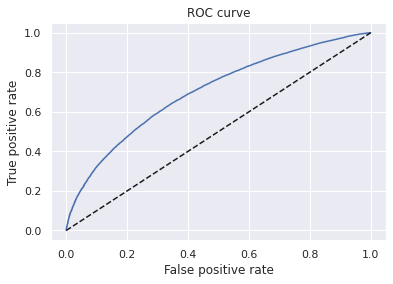

In [90]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [91]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

0.702162665953006

### Gini and Kolmogorov-Smirnov

In [92]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
# Sorts a dataframe by the values of a specific column.

In [93]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
42341,1,0.373184,0
42344,1,0.392955,0
39810,0,0.393850,0
40518,0,0.447634,0
42396,0,0.452800,0


In [94]:
df_actual_predicted_probs.tail()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
262480,1,0.991237,1
231463,1,0.991307,1
239228,1,0.991667,1
261086,1,0.992103,1
242624,1,0.992667,1


In [95]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
# We reset the index of a dataframe and overwrite it.

In [96]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,42341,1,0.373184,0
1,42344,1,0.392955,0
2,39810,0,0.393850,0
3,40518,0,0.447634,0
4,42396,0,0.452800,0


In [97]:
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.

In [98]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad
0,42341,1,0.373184,0,1,1,0
1,42344,1,0.392955,0,2,2,0
2,39810,0,0.393850,0,3,2,1
3,40518,0,0.447634,0,4,2,2
4,42396,0,0.452800,0,5,2,3


In [99]:
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
# We calculate cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
# We calculate the cumulative percentage of 'bad'.

In [100]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,42341,1,0.373184,0,1,1,0,0.000011,0.000012,0.000000
1,42344,1,0.392955,0,2,2,0,0.000021,0.000024,0.000000
2,39810,0,0.393850,0,3,2,1,0.000032,0.000024,0.000098
3,40518,0,0.447634,0,4,2,2,0.000043,0.000024,0.000196
4,42396,0,0.452800,0,5,2,3,0.000054,0.000024,0.000294


In [101]:
df_actual_predicted_probs.tail()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
93252,262480,1,0.991237,1,93253,83063,10190,0.999957,0.999952,1.0
93253,231463,1,0.991307,1,93254,83064,10190,0.999968,0.999964,1.0
93254,239228,1,0.991667,1,93255,83065,10190,0.999979,0.999976,1.0
93255,261086,1,0.992103,1,93256,83066,10190,0.999989,0.999988,1.0
93256,242624,1,0.992667,1,93257,83067,10190,1.000000,1.000000,1.0


Text(0.5, 1.0, 'Gini')

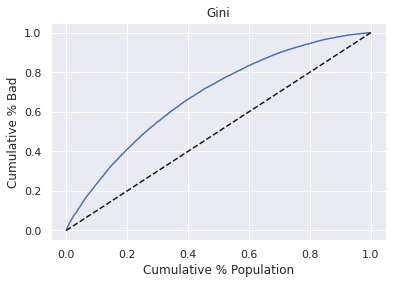

In [102]:
# Plot Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [103]:
Gini = AUROC * 2 - 1
# Here we calculate Gini from AUROC.
Gini

0.40432533190601205

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

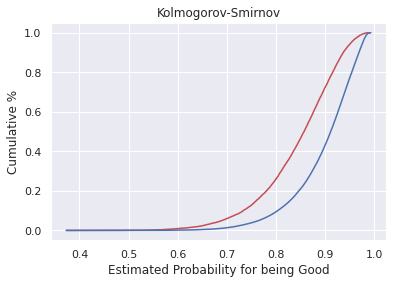

In [104]:
# Plot KS
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [105]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS

0.2966165671176936

In [106]:
pd.options.display.max_columns = None
# Sets the pandas dataframe options to display all columns/ rows.

In [107]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,0,0,0,0,1,0,0,NaN,0,1,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,1,0,0,0,0,0,0,NaN,0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [108]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.384786,NaN
1,grade:A,1.166154,3.469829e-38
2,grade:B,0.894332,8.105465e-49
3,grade:C,0.699343,2.210365e-35
4,grade:D,0.511084,9.224602e-22
5,grade:E,0.335810,1.078239e-12
6,grade:F,0.145510,2.985299e-03
7,home_ownership:OWN,0.092663,4.250673e-06
8,home_ownership:MORTGAGE,0.105567,7.177712e-17
9,addr_state:NM_VA,0.031991,3.174721e-01


In [109]:
y_hat_test_proba

array([0.92430773, 0.84975612, 0.88596508, ..., 0.97321046, 0.95979778,
       0.95239929])

In [110]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.384786,NaN
1,grade:A,1.166154,3.469829e-38
2,grade:B,0.894332,8.105465e-49
3,grade:C,0.699343,2.210365e-35
4,grade:D,0.511084,9.224602e-22
5,grade:E,0.335810,1.078239e-12
6,grade:F,0.145510,2.985299e-03
7,home_ownership:OWN,0.092663,4.250673e-06
8,home_ownership:MORTGAGE,0.105567,7.177712e-17
9,addr_state:NM_VA,0.031991,3.174721e-01


In [111]:
ref_categories

['grade:G',
 'home_ownership:RENT_OTHER_NONE_ANY',
 'addr_state:ND_NE_IA_NV_FL_HI_AL',
 'verification_status:Verified',
 'purpose:educ__sm_b__wedd__ren_en__mov__house',
 'initial_list_status:f',
 'term:60',
 'emp_length:0',
 'mths_since_issue_d:>84',
 'int_rate:>20.281',
 'mths_since_earliest_cr_line:<140',
 'inq_last_6mths:>6',
 'acc_now_delinq:0',
 'annual_inc:<20K',
 'dti:>35',
 'mths_since_last_delinq:0-3',
 'mths_since_last_record:0-2']

In [112]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list.
# We name it 'Feature name'.
df_ref_categories['Coefficients'] = 0
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['p_values'] = np.nan
# We create a third column, called 'p_values', with contains only NaN values.
df_ref_categories

,Feature name,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA_NV_FL_HI_AL,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ__sm_b__wedd__ren_en__mov__house,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [113]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
# Concatenates two dataframes.
df_scorecard = df_scorecard.reset_index()
# We reset the index of a dataframe.
df_scorecard

,index,Feature name,Coefficients,p_values
0,0,Intercept,-1.384786,NaN
1,1,grade:A,1.166154,3.469829e-38
2,2,grade:B,0.894332,8.105465e-49
3,3,grade:C,0.699343,2.210365e-35
4,4,grade:D,0.511084,9.224602e-22
5,5,grade:E,0.335810,1.078239e-12
6,6,grade:F,0.145510,2.985299e-03
7,7,home_ownership:OWN,0.092663,4.250673e-06
8,8,home_ownership:MORTGAGE,0.105567,7.177712e-17
9,9,addr_state:NM_VA,0.031991,3.174721e-01


In [114]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
# We create a new column, called 'Original feature name', which contains the value of the 'Feature name' column,
# up to the column symbol.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name
0,0,Intercept,-1.384786,NaN,Intercept
1,1,grade:A,1.166154,3.469829e-38,grade
2,2,grade:B,0.894332,8.105465e-49,grade
3,3,grade:C,0.699343,2.210365e-35,grade
4,4,grade:D,0.511084,9.224602e-22,grade
5,5,grade:E,0.335810,1.078239e-12,grade
6,6,grade:F,0.145510,2.985299e-03,grade
7,7,home_ownership:OWN,0.092663,4.250673e-06,home_ownership
8,8,home_ownership:MORTGAGE,0.105567,7.177712e-17,home_ownership
9,9,addr_state:NM_VA,0.031991,3.174721e-01,addr_state


In [115]:
min_score = 300
max_score = 850

In [116]:
df_scorecard.groupby('Original feature name')['Coefficients'].min()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.

Original feature name
Intercept                     -1.384786
acc_now_delinq                 0.000000
addr_state                     0.000000
annual_inc                    -0.068846
dti                            0.000000
emp_length                     0.000000
grade                          0.000000
home_ownership                 0.000000
initial_list_status            0.000000
inq_last_6mths                 0.000000
int_rate                       0.000000
mths_since_earliest_cr_line    0.000000
mths_since_issue_d            -0.065497
mths_since_last_delinq         0.000000
mths_since_last_record         0.000000
purpose                        0.000000
term                           0.000000
verification_status           -0.011941
Name: Coefficients, dtype: float64

In [117]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
min_sum_coef

-1.531069239914182

In [118]:

df_scorecard.groupby('Original feature name')['Coefficients'].max()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.

Original feature name
Intercept                     -1.384786
acc_now_delinq                 0.201469
addr_state                     0.517875
annual_inc                     0.573650
dti                            0.379149
emp_length                     0.126410
grade                          1.166154
home_ownership                 0.105567
initial_list_status            0.052270
inq_last_6mths                 0.652027
int_rate                       0.856433
mths_since_earliest_cr_line    0.114192
mths_since_issue_d             1.086846
mths_since_last_delinq         0.185362
mths_since_last_record         0.506376
purpose                        0.302674
term                           0.078411
verification_status            0.086111
Name: Coefficients, dtype: float64

In [119]:
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the maximum values.
max_sum_coef

5.606190083577335

In [120]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# We multiply the value of the 'Coefficients' column by the ration of the differences between
# maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.384786,NaN,Intercept,-106.712154
1,1,grade:A,1.166154,3.469829e-38,grade,89.864297
2,2,grade:B,0.894332,8.105465e-49,grade,68.917575
3,3,grade:C,0.699343,2.210365e-35,grade,53.891619
4,4,grade:D,0.511084,9.224602e-22,grade,39.384325
5,5,grade:E,0.335810,1.078239e-12,grade,25.877677
6,6,grade:F,0.145510,2.985299e-03,grade,11.213072
7,7,home_ownership:OWN,0.092663,4.250673e-06,home_ownership,7.140638
8,8,home_ownership:MORTGAGE,0.105567,7.177712e-17,home_ownership,8.135000
9,9,addr_state:NM_VA,0.031991,3.174721e-01,addr_state,2.465245


In [121]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
df_scorecard

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.384786,NaN,Intercept,311.272642
1,1,grade:A,1.166154,3.469829e-38,grade,89.864297
2,2,grade:B,0.894332,8.105465e-49,grade,68.917575
3,3,grade:C,0.699343,2.210365e-35,grade,53.891619
4,4,grade:D,0.511084,9.224602e-22,grade,39.384325
5,5,grade:E,0.335810,1.078239e-12,grade,25.877677
6,6,grade:F,0.145510,2.985299e-03,grade,11.213072
7,7,home_ownership:OWN,0.092663,4.250673e-06,home_ownership,7.140638
8,8,home_ownership:MORTGAGE,0.105567,7.177712e-17,home_ownership,8.135000
9,9,addr_state:NM_VA,0.031991,3.174721e-01,addr_state,2.465245


In [122]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
# We round the values of the 'Score - Calculation' column.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,-1.384786,NaN,Intercept,311.272642,311.0
1,1,grade:A,1.166154,3.469829e-38,grade,89.864297,90.0
2,2,grade:B,0.894332,8.105465e-49,grade,68.917575,69.0
3,3,grade:C,0.699343,2.210365e-35,grade,53.891619,54.0
4,4,grade:D,0.511084,9.224602e-22,grade,39.384325,39.0
5,5,grade:E,0.335810,1.078239e-12,grade,25.877677,26.0
6,6,grade:F,0.145510,2.985299e-03,grade,11.213072,11.0
7,7,home_ownership:OWN,0.092663,4.250673e-06,home_ownership,7.140638,7.0
8,8,home_ownership:MORTGAGE,0.105567,7.177712e-17,home_ownership,8.135000,8.0
9,9,addr_state:NM_VA,0.031991,3.174721e-01,addr_state,2.465245,2.0


In [123]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

300.0

In [124]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

850.0

In [125]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-1.384786,NaN,Intercept,311.272642,311.0,-0.272642
1,1,grade:A,1.166154,3.469829e-38,grade,89.864297,90.0,0.135703
2,2,grade:B,0.894332,8.105465e-49,grade,68.917575,69.0,0.082425
3,3,grade:C,0.699343,2.210365e-35,grade,53.891619,54.0,0.108381
4,4,grade:D,0.511084,9.224602e-22,grade,39.384325,39.0,-0.384325
5,5,grade:E,0.335810,1.078239e-12,grade,25.877677,26.0,0.122323
6,6,grade:F,0.145510,2.985299e-03,grade,11.213072,11.0,-0.213072
7,7,home_ownership:OWN,0.092663,4.250673e-06,home_ownership,7.140638,7.0,-0.140638
8,8,home_ownership:MORTGAGE,0.105567,7.177712e-17,home_ownership,8.135000,8.0,-0.135000
9,9,addr_state:NM_VA,0.031991,3.174721e-01,addr_state,2.465245,2.0,-0.465245


In [126]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard['Score - Final'][77] = 16
df_scorecard

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.384786,NaN,Intercept,311.272642,311.0,-0.272642,311.0
1,1,grade:A,1.166154,3.469829e-38,grade,89.864297,90.0,0.135703,90.0
2,2,grade:B,0.894332,8.105465e-49,grade,68.917575,69.0,0.082425,69.0
3,3,grade:C,0.699343,2.210365e-35,grade,53.891619,54.0,0.108381,54.0
4,4,grade:D,0.511084,9.224602e-22,grade,39.384325,39.0,-0.384325,39.0
5,5,grade:E,0.335810,1.078239e-12,grade,25.877677,26.0,0.122323,26.0
6,6,grade:F,0.145510,2.985299e-03,grade,11.213072,11.0,-0.213072,11.0
7,7,home_ownership:OWN,0.092663,4.250673e-06,home_ownership,7.140638,7.0,-0.140638,7.0
8,8,home_ownership:MORTGAGE,0.105567,7.177712e-17,home_ownership,8.135000,8.0,-0.135000,8.0
9,9,addr_state:NM_VA,0.031991,3.174721e-01,addr_state,2.465245,2.0,-0.465245,2.0


In [127]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

300.0

In [128]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

852.0

In [129]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,0,0,0,0,1,0,0,NaN,0,1,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,1,0,0,0,0,0,0,NaN,0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [130]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat

In [131]:
inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.

In [132]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,1,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,1,0,0,0,0,1,0,0,NaN,0,1,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,1,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,1,0,0,1,0,0,0,0,NaN,0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,1,1,0,0,0,0,0,0,NaN,0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [133]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
# Here, from the 'inputs_test_with_ref_cat_w_intercept' dataframe, we keep only the columns with column names,
# exactly equal to the row values of the 'Feature name' column from the 'df_scorecard' dataframe.

In [134]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
362514,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,NaN,NaN,1,0,1,1,1,0,0,0,0,1,0,0,0,0
288564,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,1,0,0,1,0,0,1,0,0,1,0,0,1,0
213591,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,NaN,NaN,1,0,1,0,0,0,0,0,0,1,0,0,0,0
263083,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,NaN,NaN,0,0,0,1,0,0,0,1,0,1,0,0,0,0
165001,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,NaN,NaN,1,0,1,0,0,0,0,0,0,1,0,0,0,0


In [135]:
scorecard_scores = df_scorecard['Score - Final']

In [136]:
inputs_test_with_ref_cat_w_intercept.shape

(93257, 102)

In [137]:
scorecard_scores = scorecard_scores.values.reshape(102, 1)

In [138]:
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.

In [139]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
# We divide the difference between the scores and the minimum score by
# the difference between the maximum score and the minimum score.
# Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we add the minimum sum of coefficients.

In [140]:
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score.head()

,0
362514,NaN
288564,NaN
213591,NaN
263083,NaN
165001,NaN


In [141]:
y_hat_test_proba[0: 5]

array([0.92430773, 0.84975612, 0.88596508, 0.94080553, 0.96831928])

In [142]:
df_actual_predicted_probs['y_hat_test_proba'].head()

0    0.373184
1    0.392955
2    0.393850
3    0.447634
4    0.452800
Name: y_hat_test_proba, dtype: float64

In [143]:
# We need the confusion matrix again.
#np.where(np.squeeze(np.array(loan_data_targets_test)) == np.where(y_hat_test_proba >= tr, 1, 0), 1, 0).sum() / loan_data_targets_test.shape[0]
tr = 0.95
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)
#df_actual_predicted_probs['loan_data_targets_test'] == np.where(df_actual_predicted_probs['y_hat_test_proba'] >= tr, 1, 0)

In [144]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,9595,595
1,64108,18959


In [145]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.102888,0.006380
1,0.687434,0.203298


In [146]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.3061861307998327

In [147]:
from sklearn.metrics import roc_curve, roc_auc_score

In [148]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99960746, 1.        ,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 1.20384750e-04, ...,
        9.99975923e-01, 9.99975923e-01, 1.00000000e+00]),
 array([1.99266737, 0.99266737, 0.9907113 , ..., 0.48347241, 0.39385004,
        0.37318392]))

In [149]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

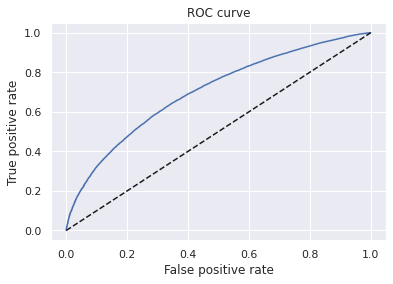

In [151]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [152]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# We concatenate 3 dataframes along the columns.

In [153]:
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
# We name the columns of the dataframe 'thresholds', 'fpr', and 'tpr'.

In [154]:
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)
# Let the first threshold (the value of the thresholds column with index 0) be equal to a number, very close to 1
# but smaller than 1, say 1 - 1 / 10 ^ 16.

In [155]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
# The score corresponsing to each threshold equals:
# The the difference between the natural logarithm of the ratio of the threshold and 1 minus the threshold and
# the minimum sum of coefficients
# multiplied by
# the sum of the minimum score and the ratio of the difference between the maximum score and minimum score and 
# the difference between the maximum sum of coefficients and the minimum sum of coefficients.

In [156]:
df_cutoffs['Score'][0] = max_score

In [157]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, if given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold.
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

In [158]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# Rejection rate equals one minus approval rate.

In [159]:
df_cutoffs.iloc[5000: 6200, ]
# Here we display the dataframe with cutoffs form line with index 5000 to line with index 6200.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5000,0.903565,0.259470,0.548040,590.0,48168,45089,0.516508,0.483492
5001,0.903560,0.259470,0.548076,590.0,48171,45086,0.516540,0.483460
5002,0.903559,0.259568,0.548076,590.0,48172,45085,0.516551,0.483449
5003,0.903544,0.259568,0.548148,590.0,48178,45079,0.516615,0.483385
5004,0.903541,0.259666,0.548148,590.0,48179,45078,0.516626,0.483374
5005,0.903438,0.259666,0.548702,590.0,48225,45032,0.517119,0.482881
5006,0.903435,0.259863,0.548702,590.0,48227,45030,0.517141,0.482859
5007,0.903422,0.259863,0.548750,590.0,48231,45026,0.517184,0.482816
5008,0.903418,0.260059,0.548750,590.0,48233,45024,0.517205,0.482795
5009,0.903411,0.260059,0.548798,590.0,48237,45020,0.517248,0.482752


In [160]:
df_cutoffs.iloc[1000: 2000, ]
# Here we display the dataframe with cutoffs form line with index 1000 to line with index 2000.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1000,0.953323,0.048871,0.206099,650.0,17618,75639,0.188919,0.811081
1001,0.953323,0.048970,0.206099,650.0,17619,75638,0.188930,0.811070
1002,0.953318,0.048970,0.206123,650.0,17621,75636,0.188951,0.811049
1003,0.953318,0.049068,0.206123,650.0,17622,75635,0.188962,0.811038
1004,0.953309,0.049068,0.206147,650.0,17624,75633,0.188983,0.811017
1005,0.953307,0.049166,0.206147,650.0,17625,75632,0.188994,0.811006
1006,0.953294,0.049166,0.206219,650.0,17631,75626,0.189058,0.810942
1007,0.953294,0.049264,0.206219,650.0,17632,75625,0.189069,0.810931
1008,0.953280,0.049264,0.206267,650.0,17636,75621,0.189112,0.810888
1009,0.953279,0.049362,0.206267,650.0,17637,75620,0.189123,0.810877


In [161]:
inputs_train_with_ref_cat.to_csv('inputs_train_with_ref_cat.csv')

In [162]:
df_scorecard.to_csv('df_scorecard.csv')
#storing the scorecard

In [163]:
# # this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# # specify the repo_version depending on your preference.
# #container = get_image_uri(boto3.Session().region_name,
#                           'xgboost', 
#                           repo_version='1.0-1')

In [164]:
# # initialize hyperparameters
# hyperparameters = {
#         "max_depth":"5",
#         "eta":"0.2",
#         "gamma":"4",
#         "min_child_weight":"6",
#         "subsample":"0.7",
#         "objective":"binary:logistic",
#         "num_round":50
#         }

In [165]:
# # construct a SageMaker estimator that calls the xgboost-container
# estimator = sagemaker.estimator.Estimator(container, 
#                                           hyperparameters=hyperparameters,
#                                           role=sagemaker.get_execution_role(),
#                                           train_instance_count=1, 
#                                           train_instance_type='ml.t3.large', 
#                                           train_volume_size=1, # 1 GB 
#                                           output_path=output_path,
#                                           train_use_spot_instances=True,
#                                           train_max_run=300,
#                                           train_max_wait=600)

In [166]:
# sess = sagemaker.Session()
# xgb = sagemaker.estimator.Estimator(containers[my_region],role, train_instance_count=1, train_instance_type='ml.t3.large',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
# xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

In [167]:
# import utils.config as cfg

# config = cfg.get_config()
# region = config['region']
# bucket_name = config['bucket_name']
# bucket_prefix = config['bucket_prefix']
# sgmk_session = config['sgmk_session']
# sgmk_role = config['sgmk_role']

# train_uri = cfg.get_s3_path('train')
# val_uri = cfg.get_s3_path('validation')

# # specify container
# training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.0-1")

# # Define the data input channels for the training job:
# s3_input_train = sagemaker.inputs.TrainingInput(train_uri, content_type="csv")
# s3_input_validation = sagemaker.inputs.TrainingInput(val_uri, content_type="csv")

# print(f"{s3_input_train.config}\n\n{s3_input_validation.config}")

# # Instantiate an XGBoost estimator object
# estimator = sagemaker.estimator.Estimator(
#     image_uri=training_image,  # XGBoost algorithm container
#     instance_type="ml.t3.large",  # type of training instance
#     instance_count=1,  # number of instances to be used
#     role=sgmk_role,  # IAM role to be used
#     max_run=20*60,  # Maximum allowed active runtime
#     use_spot_instances=True,  # Use spot instances to reduce cost
#     max_wait=30*60,  # Maximum clock time (including spot delays)
# )

# print("Estimator: ", estimator)

# # define its hyperparameters
# estimator.set_hyperparameters(
#     num_round=150,     # int: [1,300]
#     max_depth=5,     # int: [1,10]
#     alpha=2.5,         # float: [0,5]
#     eta=0.5,           # float: [0,1]
#     objective="binary:logistic",
# )

# print("Starting training...")
# # start a training (fitting) job
# estimator.fit({ "train": s3_input_train, "validation": s3_input_validation })
# print("Done.")

In [168]:
# s3_input_train = sagemaker.inputs.TrainingInput(
#     s3_data="s3://{}/train".format(bucket), content_type="csv"
# )

In [169]:
# estimator.fit({'train': s3_input_train,'validation': s3_input_test})

In [170]:
# # DEploying Machine learning model as endpoints
# xgb_predictor=estimator.deploy(initial_instance_count=1,instance_type='ml.t3.large')